# Double Slit Experiment with Single Photon and Normal Double slit

In [7]:
%matplotlib inline

from scipy import stats
from decimal import Decimal
import statsmodels.formula.api as sm
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import gridspec


params = {
   'axes.labelsize': 18,
   'font.size': 24,
   'legend.fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'axes.titlesize':18,
   'text.usetex': False,
   'figure.figsize': [8, 6],
   'font.family':'serif',
   'font.serif':'Computer Modern Roman' 
   }
mpl.rcParams.update(params)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{bm}']

In [8]:
# Experiment Parameters
l = 0.50 # in metres
u_l = 0.005 

b = 0.085e-3 # in metres
a = 0.356e-3 # in metres

## Double Slit with Red Laser

In [45]:
data = np.genfromtxt('doubleslit2.csv',delimiter=',')
data2 = np.genfromtxt('doubleslit1.csv',delimiter=',')

dark = 8.1e-3
u_dark = 0.05e-3

In [46]:
def data_extraction(data):
    volt = data[:,2]*1e-3 # voltage in volts
    pos = (data[:,0] - data[:,0][np.argmax(volt)])*1e-3 # Position in metres
    u_pos = data[:,1]*1e-3
    u_volt = data[:,3]*1e-3
    
    if pos[-1] < 0:
        u_pos = u_pos[::-1]
        pos = pos[::-1]
        volt = volt[::-1]
        u_volt = u_volt[::-1]
        
    
    return pos, u_pos, volt, u_volt
    
pos, u_pos, volt, u_volt = data_extraction(data)

volt -= dark*np.ones(len(volt))
u_volt_true = np.sqrt(u_volt**2+(u_dark*np.ones(len(volt)))**2)

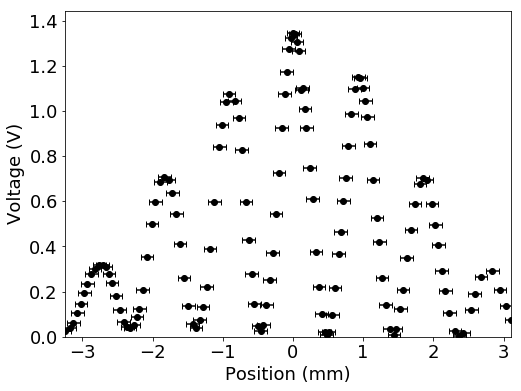

In [47]:
def plot_slit(pos, u_pos, volt, u_volt_true):
    plt.errorbar(pos*1e3, volt, yerr=u_volt_true*3, xerr=u_pos*1e3*3,color='k',ecolor='k',fmt='o',capsize=3)
    plt.xlabel(r'Position (mm)')
    plt.ylabel(r'Voltage (V)')
    plt.xlim(pos[0]*1e3,pos[-1]*1e3)
    plt.ylim(0,max(volt)+0.1)

    plt.show()
    
plot_slit(pos, u_pos, volt, u_volt_true)

### Fitting to the Double Slit Data

We need to fit to the plot shown above, this is done by considering the formula:

$$ I(x) = 4I_0 \Big(\frac{\sin(\beta)}{\beta}\Big)^2\cos^{2}(\alpha)$$ 
with $\alpha = \pi a x / L \lambda $, where $a$ is the double slit separation, L is the distance between the double slit and the detector slit, and $\lambda$ is the wavelength. And $\beta = \pi b x/ L\lambda $, where $b$ is the single slit width.   

In [48]:
def intensity(x,*popt):
    ar, br, i0 = popt
    
    alpha = np.pi*ar*x # note ar and br are really b/(lambda*l) and a/(lambda*l)
    beta = br*x
    
    return i0*(np.sinc(beta))**2*(np.cos(alpha))**2

Now we shall do the fitting:

In [49]:
popt, pcov = curve_fit(intensity, pos, volt, p0=[a/(l*670e-9),b/(l*670e-9)*np.pi,0.35],sigma=u_volt)
perr = np.sqrt(np.diag(pcov))
print('ratio of a/lambda*l is: %0.3E +- %0.1E m^-2' % (Decimal(popt[0]),Decimal(perr[0])))
print('ratio of b/lambda*l is: %0.4E +- %0.1E m^-2' % (Decimal(popt[1]),Decimal(perr[1])))
print('Intensity is: %0.4E +- %0.1E ' % (Decimal(popt[2]),Decimal(perr[2])))

ratio of a/lambda*l is: 1.068E+03 +- 2.1E+00 m^-2
ratio of b/lambda*l is: -2.1950E+02 +- 3.2E+00 m^-2
Intensity is: 1.3045E+00 +- 1.6E-02 


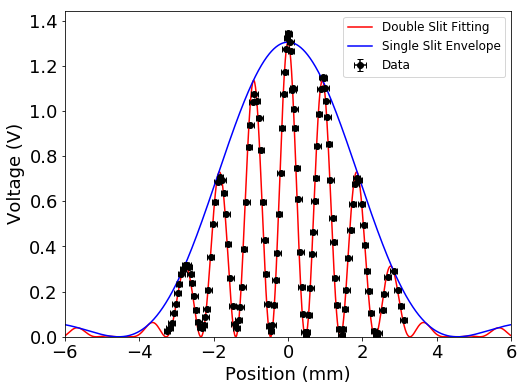

In [73]:
def error_plot(pos, u_pos, volt, u_volt_true, popt):
    
    x_array = np.linspace(-0.05,0.05,10000)

    pos_n = pos*1e3
    
    plt.plot(x_array*1e3,intensity(x_array,*popt),color='r',linestyle='-', label = 'Double Slit Fitting')
    plt.errorbar(pos_n, volt, yerr=u_volt_true*3, xerr=u_pos*1e3*3,color='k',ecolor='k',fmt='o',capsize=3, label = 'Data')
    plt.plot(x_array*1e3,intensity_single(x_array,popt[1],popt[2]),color='b', label="Single Slit Envelope")
    plt.xlabel(r'Position (mm)')
    plt.ylabel(r'Voltage (V)')
    plt.xlim(-6,6)
    plt.ylim(0,max(volt)+0.1)
    plt.legend(loc='best',fontsize='12')
    plt.show()
    
error_plot(pos, u_pos, volt, u_volt_true, popt)

Therefore, we find $a$ and $b$ below, given the wavelength was $\lambda= 670\pm5\text{ nm}$ and the distance from 
S2 to S3 was 0.498$\pm$0.0005 m.

In [41]:
wav = 670e-6
u_wav = 5e-6

a_calc = abs(popt[0]*wav*l) # in mm
b_calc = abs(popt[1]*wav*l) # in mm

u_a_calc = a_calc*np.sqrt((u_wav/wav)**2+(u_l/l)**2)
u_b_calc = b_calc*np.sqrt((u_wav/wav)**2+(u_l/l)**2)

print('Calculated a to be %0.2E +- %0.0E mm compared to the true value of 3.56E-01 mm' %  (Decimal(a_calc),
                                                                                          Decimal(u_a_calc)))
print('Calculated b to be %0.2E +- %0.0E mm compared to the true value of 8.5E-02 mm' %  (Decimal(b_calc),
                                                                                          Decimal(u_b_calc)))

Calculated a to be 3.58E-01 +- 4E-03 mm compared to the true value of 3.56E-01 mm
Calculated b to be 7.35E-02 +- 9E-04 mm compared to the true value of 8.5E-02 mm


Let's do this calculation for the other data set from this part of experiment!

In [56]:
pos2, u_pos2, volt2, u_volt2 = data_extraction(data2)

volt2 -= dark*np.ones(len(volt2))
u_volt_true2 = np.sqrt(u_volt2**2+(u_dark*np.ones(len(volt2)))**2)

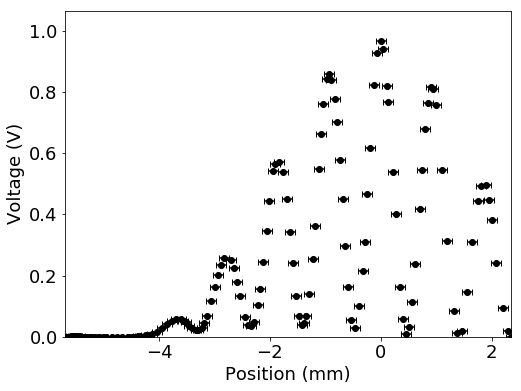

In [57]:
plot_slit(pos2, u_pos2, volt2, u_volt_true2)

In [58]:
popt2, pcov2 = curve_fit(intensity, pos2, volt2, p0=[a/(l*670e-9),b/(l*670e-9),0.35],sigma=u_volt2)
perr2 = np.sqrt(np.diag(pcov2))
print('ratio of a/lambda*l is: %0.3E +- %0.1E m^-2' % (Decimal(popt2[0]),Decimal(perr2[0])))
print('ratio of b/lambda*l is: %0.4E +- %0.1E m^-2' % (Decimal(popt2[1]),Decimal(perr2[1])))
print('Intensity is: %0.4E +- %0.1E ' % (Decimal(popt2[2]),Decimal(perr2[2])))

ratio of a/lambda*l is: 1.067E+03 +- 1.4E+00 m^-2
ratio of b/lambda*l is: 2.1074E+02 +- 1.9E+00 m^-2
Intensity is: 9.5720E-01 +- 6.0E-03 


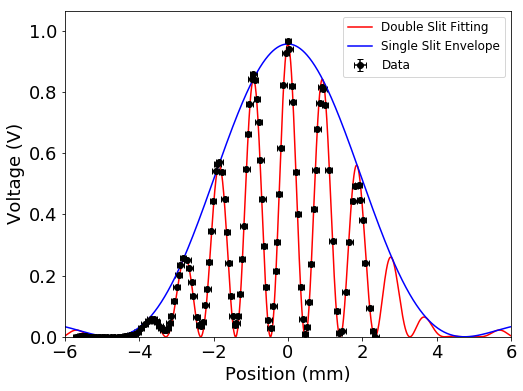

In [74]:
error_plot(pos2, u_pos2, volt2, u_volt_true2, popt2)

In [60]:
wav = 670e-6
u_wav = 5e-6

a_calc2 = abs(popt2[0]*wav*l) # in mm
b_calc2 = abs(popt2[1]*wav*l) # in mm

u_a_calc2 = a_calc2*np.sqrt((u_wav/wav)**2+(u_l/l)**2)
u_b_calc2 = b_calc2*np.sqrt((u_wav/wav)**2+(u_l/l)**2)

print('Calculated a to be %0.2E +- %0.0E mm compared to the true value of 3.56E-01 mm' %  (Decimal(a_calc2),
                                                                                          Decimal(u_a_calc2)))
print('Calculated b to be %0.2E +- %0.0E mm compared to the true value of 8.5E-02 mm' %  (Decimal(b_calc2),
                                                                                          Decimal(u_b_calc2)))

Calculated a to be 3.58E-01 +- 4E-03 mm compared to the true value of 3.56E-01 mm
Calculated b to be 7.06E-02 +- 9E-04 mm compared to the true value of 8.5E-02 mm


## Single Slit Envelope

Now, we need to consider the single slit data and results

In [63]:
data3 = np.genfromtxt('singleslit.csv',delimiter=',')

dark = 8.1e-3
u_dark = 0.05e-3

In [64]:
pos3, u_pos3, volt3, u_volt3 = data_extraction(data3)

volt3 -= dark*np.ones(len(volt3))
u_volt_true3 = np.sqrt(u_volt3**2+(u_dark*np.ones(len(volt3)))**2)

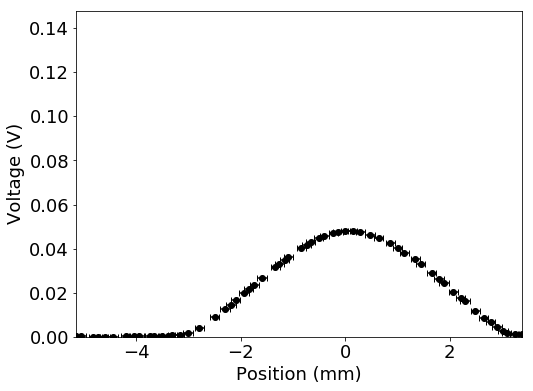

In [65]:
plot_slit(pos3, u_pos3, volt3, u_volt_true3)

In [66]:
def intensity_single(x,*popt):
    br, i0 = popt
    
    # note ar and br are really b/(lambda*l) and a/(lambda*l)
    beta = br*x
    
    return i0*(np.sinc(beta))**2

In [67]:
popt3, pcov3 = curve_fit(intensity_single, pos3, volt3, p0=[b/(l*670e-9),0.05],sigma=u_volt3)
perr3 = np.sqrt(np.diag(pcov3))

br3, i03 = popt[0],popt[1]
u_br3, u_i03 = perr[0], perr[1]

print('ratio of b/lambda*l is: %0.3E +- %0.1E m^-2' % (Decimal(br3),Decimal(u_br3)))
print('Intensity is: %0.4E +- %0.1E ' % (Decimal(i03),Decimal(u_i03)))

ratio of b/lambda*l is: 1.068E+03 +- 2.1E+00 m^-2
Intensity is: -2.1950E+02 +- 3.2E+00 


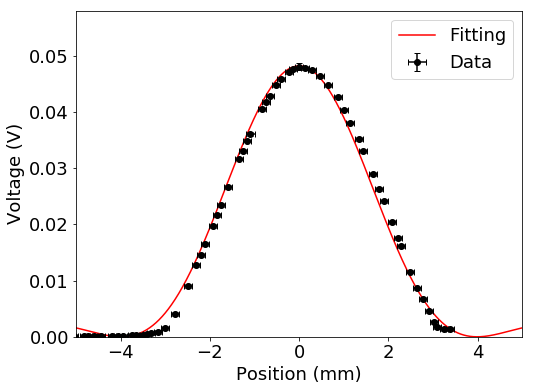

In [71]:
def error_plot_single(pos, u_pos, volt, u_volt_true, popt):
    
    x_array = np.linspace(-0.005,0.005,1000)

    pos_n = pos*1e3
    
    plt.plot(x_array*1e3,intensity_single(x_array,*popt),color='r',linestyle='-', label = 'Fitting')
    plt.errorbar(pos_n, volt, yerr=u_volt_true*3, xerr=u_pos*1e3*3,color='k',ecolor='k',fmt='o',capsize=3, label ='Data')
    plt.xlabel(r'Position (mm)')
    plt.ylabel(r'Voltage (V)')
    plt.xlim(-5,5)
    plt.ylim(0,max(volt)+0.01)
    plt.legend(loc='best')
    plt.show()

error_plot_single(pos3, u_pos3, volt3, u_volt_true3, popt3)

In [69]:
b_calc3 = abs(popt3[0]*wav*l) # in mm
u_b_calc3 = b_calc3*np.sqrt((u_wav/wav)**2+(u_l/l)**2)
print('Calculated b to be %0.2E +- %0.0E mm compared to the true value of 8.5E-02 mm' %  (Decimal(b_calc3),
                                                                                          Decimal(u_b_calc3)))

Calculated b to be 8.40E-02 +- 1E-03 mm compared to the true value of 8.5E-02 mm


## Light-Dark Counts and Stuff

In [27]:
data_light = np.genfromtxt('lightdark.csv',delimiter=',')

In [28]:
def data_extraction_light(data):
    volt = data[:,0]
    u_volt = data[:,1]
    light = data[:,2]
    u_light = data[:,3]
    dark = data[:,4]
    u_dark = data[:,5]
        
    
    return volt, u_volt, light, u_light, dark, u_dark

volt, u_volt, light, u_light, dark, u_dark = data_extraction_light(data_light)

In [29]:
ratio = light/dark

u_ratio = ratio*np.sqrt((u_light/light)**2+(u_dark/dark)**2)

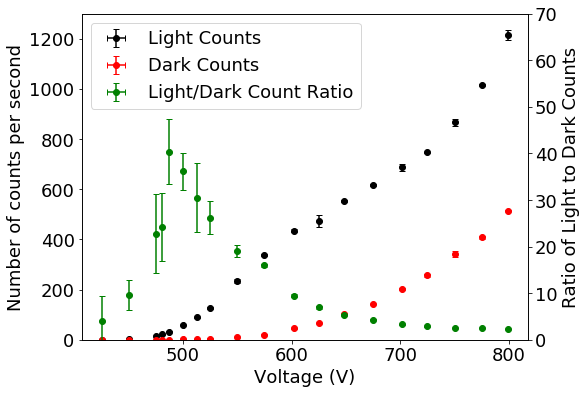

In [30]:
fig, ax1 = plt.subplots()

l1 = ax1.errorbar(volt,light,xerr=u_volt,yerr=u_light,color='k',ecolor='k',fmt='o',capsize=3,label=r'Light Counts')

ax1.set_ylabel(r'Number of counts per second')
ax1.set_xlabel(r'Voltage (V)')
ax1.set_ylim(0,1300)

ax2 = ax1.twinx()

l2 = ax1.errorbar(volt,dark,xerr=u_volt,yerr=u_dark,color='r',ecolor='r',fmt='o',capsize=3,label=r'Dark Counts')

l3 = ax2.errorbar(volt,ratio,xerr=u_volt,yerr=u_ratio,color='g',ecolor='g',fmt='o',capsize=3,label=r'Light/Dark Count Ratio')

ax2.set_ylabel(r'Ratio of Light to Dark Counts')
ax2.set_ylim(0,70)

# added these three lines
lns = [l1,l2,l3]
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=2)

## Fitting to Single Photon Data

In [31]:
data_p = np.genfromtxt('singlephoton.csv',delimiter=',')

dark = 1
u_dark = 0.5

In [32]:
def data_extraction_p(data):
    volt = data[:,2] # voltage in volts
    pos = (data[:,0] - data[:,0][np.argmax(volt)])*1e-3 # Position in metres
    u_pos = data[:,1]*1e-3
    u_volt = data[:,3]
    
    if pos[-1] < 0:
        u_pos = u_pos[::-1]
        pos = pos[::-1]
        volt = volt[::-1]
        u_volt = u_volt[::-1]
        
    
    return pos, u_pos, volt, u_volt

In [33]:
pos_p, u_pos_p, volt_p, u_volt_p = data_extraction_p(data_p)

volt_p -= dark*np.ones(len(volt_p))
u_volt_true_p = np.sqrt(u_volt_p**2+(u_dark*np.ones(len(volt_p)))**2)

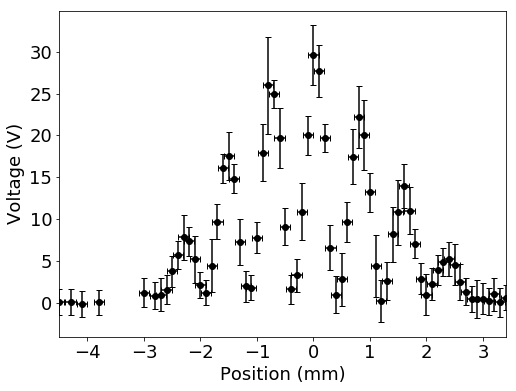

In [34]:
def plot_slit(pos, u_pos, volt, u_volt_true):
    plt.errorbar(pos*1e3, volt, yerr=u_volt_true*3, xerr=u_pos*1e3*3,color='k',ecolor='k',fmt='o',capsize=3)
    plt.xlabel(r'Position (mm)')
    plt.ylabel(r'Voltage (V)')
    plt.xlim(pos[0]*1e3,pos[-1]*1e3)
    #plt.ylim(0,max(volt)+0.1)

    plt.show()

plot_slit(pos_p, u_pos_p, volt_p, u_volt_true_p)

In [35]:
popt_p, pcov_p = curve_fit(intensity, pos_p, volt_p, p0=[a/(l*510e-9),b/(l*510e-9),30],sigma=u_volt_p)
perr_p = np.sqrt(np.diag(pcov_p))
print('ratio of a/lambda*l is: %0.3E +- %0.1E m^-2' % (Decimal(popt2[0]),Decimal(perr2[0])))
print('ratio of b/lambda*l is: %0.4E +- %0.1E m^-2' % (Decimal(popt2[1]),Decimal(perr2[1])))
print('Intensity is: %0.4E +- %0.1E ' % (Decimal(popt2[2]),Decimal(perr2[2])))

ratio of a/lambda*l is: 1.067E+03 +- 1.4E+00 m^-2
ratio of b/lambda*l is: 2.1074E+02 +- 1.9E+00 m^-2
Intensity is: 9.5720E-01 +- 6.0E-03 


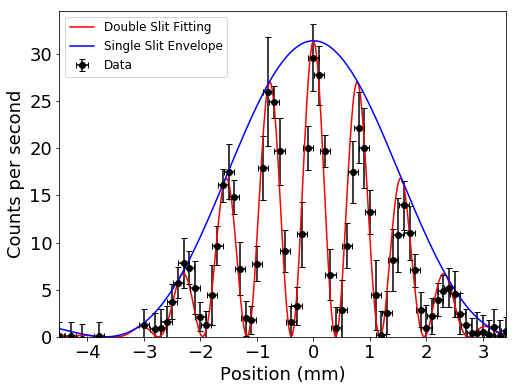

In [72]:
def error_plot_p(pos, u_pos, volt, u_volt_true, popt):
    
    x_array = np.linspace(pos[-1],pos[0],250)

    pos_n = pos*1e3
    
    plt.plot(x_array*1e3,intensity(x_array,*popt),color='r',linestyle='-', label='Double Slit Fitting')
    plt.plot(x_array*1e3,intensity_single(x_array,popt[1],popt[2]),color='b',label='Single Slit Envelope')
    plt.errorbar(pos_n, volt, yerr=u_volt_true*3, xerr=u_pos*1e3*3,color='k',ecolor='k',fmt='o',capsize=3, label = 'Data')
    plt.xlabel(r'Position (mm)')
    plt.ylabel(r'Counts per second')
    plt.xlim(pos_n[0],pos_n[-1])
    plt.ylim(0,max(volt)+5)
    plt.legend(loc='best',fontsize='12')
    plt.show()
    
error_plot_p(pos_p, u_pos_p, volt_p, u_volt_true_p, popt_p)

In [37]:
wav = 546e-6
u_wav = 5e-6

a_calc_p = abs(popt_p[0]*wav*l) # in mm
b_calc_p = abs(popt_p[1]*wav*l) # in mm

u_a_calc_p = a_calc_p*np.sqrt((u_wav/wav)**2+(u_l/l)**2)
u_b_calc_p = b_calc_p*np.sqrt((u_wav/wav)**2+(u_l/l)**2)

print('Calculated a to be %0.2E +- %0.0E mm compared to the true value of 3.56E-01 mm' %  (Decimal(a_calc_p),
                                                                                          Decimal(u_a_calc_p)))
print('Calculated b to be %0.2E +- %0.0E mm compared to the true value of 8.5E-02 mm' %  (Decimal(b_calc_p),
                                                                                          Decimal(u_b_calc_p)))

Calculated a to be 3.48E-01 +- 5E-03 mm compared to the true value of 3.56E-01 mm
Calculated b to be 7.40E-02 +- 1E-03 mm compared to the true value of 8.5E-02 mm
